In [1]:
import gym
import pandas as pd
import numpy as np
from stable_baselines3 import DQN
import yfinance as yf

2024-03-11 16:22:59.043298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 16:23:00.101551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def calculate_rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = [np.nan] * (n - 1) + [100. - 100. / (1. + rs)]

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # Cambio actual
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi.append(100. - 100. / (1. + rs))

    return rsi

In [3]:
data = yf.download('GOOG', start='2010-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values)
dates = np.array(data.index.values).astype('datetime64[ns]')
rsi = calculate_rsi(prices)



[*********************100%%**********************]  1 of 1 completed


## Enviroment

In [34]:
import gymnasium as gym2
import gym_anytrading
from gym_anytrading.datasets import STOCKS_GOOGL
import matplotlib.pyplot as plt

info: {'total_reward': 33.864583015441895, 'total_profit': 3.0470110253820757e-05, 'position': <Positions.Long: 1>}


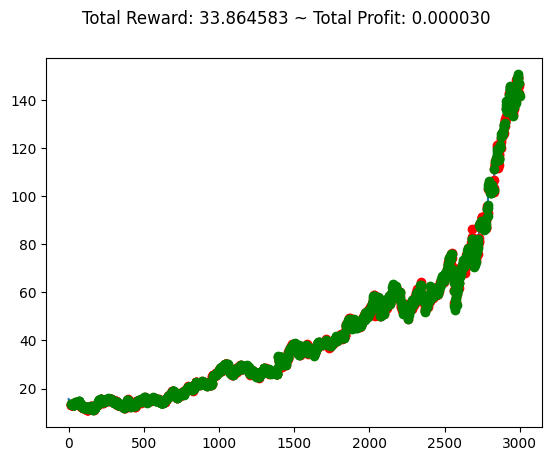

In [39]:
def reward_function(state, action, reward):
    # Cálculo de la rentabilidad
    profit = state['Close'] - state['Open']

    # Cálculo del RSI
    rsi = state['RSI_14']

    # Recompensa por comprar en zona de sobreventa
    if action == gym_anytrading.actions.Buy and rsi < 30:
        reward += 0.1

    # Recompensa por vender en zona de sobrecompra
    if action == gym_anytrading.actions.Sell and rsi > 70:
        reward += 0.1

    # Penalización por mantener una posición abierta durante mucho tiempo
    if state['Time'] > 100:
        reward -= 0.01

    # Recompensa por la rentabilidad obtenida
    reward += profit * rsi

    return reward

env = gym2.make(
    'stocks-v0',
    df=data,
    window_size=14,
    frame_bound=(14, 3000)
)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()


In [28]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (14, 2)
> df.shape: (3522, 6)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 4.8811082627150855
